# Lent Practical 4: A 3 Box Ocean

Over the next three practicals you'll be building up a 4-box model of carbon in the ocean and atmosphere, which incorporates physical, chemical and biological processes, and involves multiple interacting components.

In this practical, you'll start by creating a 3-box ocean model that everything else will be built on. As discussed in lectures, we're using a 3-box model because it's the simplest possible configuration that allows us to represent both thermohaline circulation (with a latitudinal density gradient), and the separation of the surface and deep ocean, both of which are necessary to represent carbon in the ocean.

Today, you'll be introduced to the overall structure of the model by setting up the transport of two conservative quantities - salt and heat, and their modification by evaporation, precipitation and heat exchange at the surface which will drive water circulation in the model.

## Tips for the Term

 - We will build up this model gradually. Each of the next three practicals will add one new process to the model. This means that each new practical will contain code that solves the previous practicals.
 - It will be much easier to understand the model if you keep up with the practicals through the term, rather than leaving them all to the last minute, because...
 - In the last practical you will be given a choice of two questions for the long section of the lab report. Both of these will require you to modify the model you have built to understand some component of the carbon cycle. You will find it much easier to attempt these if you have worked through all of the preceding practicals.

## Packages

The code block below will install a package called 'OceanTools', which contains some useful functions that you can use to visualise your model runs.

In [1]:
# This code installs some required packages for the rest of the notebook. Run this once at the start - it should take <30 seconds to run.
import os
if not os.path.exists('./OceanTools'):
    !git clone https://github.com/Quantitative-Environmental-Science/OceanTools.git

import sys
sys.path.append('./OceanTools')

!pip install cbsyst

import numpy as np
import matplotlib.pyplot as plt

Cloning into 'OceanTools'...
remote: Enumerating objects: 198, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 198 (delta 54), reused 43 (delta 28), pack-reused 123 (from 1)
Receiving objects: 100% (198/198), 532.95 KiB | 2.69 MiB/s, done.
Resolving deltas: 100% (110/110), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.1 MB/s eta 0:00:00


<img src="https://github.com/Quantitative-Environmental-Science/OceanTools/raw/main/figs/Ocean_3box.png" align="right" width="40%" style="align: right; min-width: 30em; margin-left: 3em; margin-right: 3em; margin-bottom: 3em">

## A 3 Box Ocean

###  Model Geometry

There is a single box representing the deep ocean ($D$), overlain by two boxes representing the surface ocean at the high ($H$) and low ($L$) latitudes. There is a single box representing the atmosphere ($A$) overlying both surface boxes. Each box is modelled as a homogeneous mass with uniform physical and chemical properties.

The high latitude surface box represents 15% of the total ocean surface area, and has a depth of 200 m. The low latitude box is 85% of the ocean surface area, with a depth of 100 m. This depth difference reflects geographic variation in the depth of the mixed layer, which tends to be deeper at high latitudes where winds are more intense and waves are larger, and shallower in the tropics where there is more temperature-driven stratification.

The first step in constructing our model is to set up the processes that will create a density gradient that causes water to circulate around our boxes.
This is conceptually similar to the Lorenz and Stommel models you encountered in the last two practicals, but the geometry of our boxes is different to accommodate the inclusion of biogeochemical processes that operate in the surface ocean.

### Physical Ocean Model

We must include two mixing processes to describe the movement of water around our model:
- **Thermohaline Circulation** ($Q_T$) is a unidirectional current that moves a fixed volume from $L \rightarrow H \rightarrow D \rightarrow L \rightarrow$ etc. This is driven by density differences between the surface boxes. Water density depends on temperature and salinity, so using the same approach as the last practical we can calculate $Q_T$ as:
  $$
  Q_T = k (\alpha \Delta T - \beta \Delta S)
  $$
  where $\alpha$ and $\beta$ convert changes in T and S into density differences and $k$ is a rate constant.

- **Surface-Deep Mixing** exchanges water between the deep and surface ocean and takes place in both high and low latitude surface boxes. For convenience, we'll describe this using a mixing timescale for each box ($\tau_H$ and $\tau_L$), which is related to a volume flux via:
  $$
  Q_x = \frac{V_x}{\tau_x}
  $$

Using these fluxes we can write down an expression for the change in concentration of a conservative tracer ($C$) in each box:
$$
\begin{align}
\frac{dC_L}{dt} &= \left. \left(Q_T (C_D - C_L) - \frac{V_L}{\tau_{mL}} (C_L - C_D) \right) \middle/ V_L \right. \\
\frac{dC_H}{dt} &= \left. \left((Q_T (C_L - C_H) - \frac{V_H}{\tau_{mH}} (C_H - C_D) \right) \middle/ / V_H \right. \\
\frac{dC_D}{dt} &= \left. \left((Q_T (C_H - C_D) - \frac{V_L}{\tau_{mL}} (C_D - C_L) - \frac{V_H}{\tau_{mH}} (C_D - C_H) \right) \middle/ / V_D \right. \\
\end{align}
$$

To drive circulation, we must include temperature ($T$) and salinity ($S$) in the model.

### Temperature

We will model heat exchange with the atmosphere using an equilibration timescale, $\tau^T$, which describes how quickly the temperature of a surface box will equilibrate with the overlying atmosphere.

$$
\begin{align}
\frac{dT_L}{dt} &= \left. \left(Q_T (T_D - T_L) - \frac{V_L}{\tau_{mL}} (T_L - T_D) - \frac{V_L}{\tau_T} (T_L - T_A ) \right) \middle/ V_L \right. \\
\frac{dT_H}{dt} &= \left. \left(Q_T (T_L - T_H) - \frac{V_H}{\tau_{mH}} (T_H - T_D) - \frac{V_H}{\tau_T} (T_H - T_A) \right) \middle/ V_H \right. \\
\frac{dT_D}{dt} &= \left. \left(Q_T (T_H - T_D) - \frac{V_L}{\tau_{mL}} (T_D - T_L) - \frac{V_H}{\tau_{mH}} (T_D - T_H) \right) \middle/ V_D \right. \\
\end{align}
$$

### Salinity

We will model salinity changes by adding a term that describes the concentration or dilution of water by evaporation or precipitation.
This term, $E$, is the total moles of salt added or removed at the surface ocean, and is the same as in the Stommel model.
This will be positive in the low latitudes where evaporation dominates (evaporation-precipitation is positive), and negative in the high latitudes where rainfall adds fresh water to the ocean (evaporation-precipitation is negative).

$$
\begin{align}
\frac{dS_L}{dt} &= \left. \left(Q_T (S_D - S_L) - \frac{V_L}{\tau_{mL}} (S_L - S_D) + E \right) \middle/ V_L \right. \\
\frac{dS_H}{dt} &= \left. \left(Q_T (S_L - S_H) - \frac{V_H}{\tau_{mH}} (S_H - S_D) - E \right) \middle/ V_H \right. \\
\frac{dS_D}{dt} &= \left. \left(Q_T (S_H - S_D) - \frac{V_L}{\tau_{mL}} (S_D - S_L) - \frac{V_H}{\tau_{mH}} (S_D - S_H) \right) \middle/ V_D \right. \\
\end{align}
$$

### Model Setup

#### Global Variables
The cell below contains a number of variables that you will use to construct your model.

In [2]:
# global variables
V_ocean = 1.34e18  # volume of the ocean in m3 (note that the 'eX' in python denotes 'x10^X')
SA_ocean = 358e12  # surface area of the ocean in m2
fSA_hilat = 0.15  # fraction of ocean surface area in 'high latitude' box

# variables used to calculate Q
Q_alpha = 1e-4
Q_beta = 7e-4
Q_k = 8.3e17

# salinity balance - the total amount of salt added or removed to the surface boxes
Fw = 0.1  # low latitude evaporation - precipitation in units of m yr-1
Sref = 35  # reference salinity in units of g kg-1
E = Fw * SA_ocean * (1 - fSA_hilat) * Sref  # amount of salt added to the low latitude box,  g kg-1 yr-1, ~ kg m-3 yr-1

#### Boxes

So far in this course, you have stored individual state variables (e.g. temperature, salinity) in individual arrays.
We're going to us a different approach here, because as your model grows you will have to keep track of an increasing number of variables in each box of the model.
We're therefore going to keep track of all the attributes and state variables of the model in a `dictionary`.

A `dictionary` is a way of storing multiple pieces of labelled data within a single Python variable, which allows you to access the values using the corresponding key. For example:

```python
# define a dictionary
example_dict = {
    'name': 'Colin',
    'age': 30,
}

# access a value
example_dict['name']

  > 30
```


We define a `dictionary` using curly brackets (`{}`), with multiple `key`: `value` entries separated by commas. The keys and values in a `dictionary` can be anything, including arrays, lists or nested dictionaries, which makes dictionaries a very convenient way to store and access complex data. Further information and examples of how to use dictionaries can be found [here](https://docs.python.org/3/tutorial/datastructures.html#dictionaries).

For example, to create the dictionary for the high latitude box:

In [3]:
# set up initial values for the boxes
init_hilat = {
    'name': 'hilat',
    'depth': 200,  # box depth, m
    'SA': SA_ocean * fSA_hilat,  # box surface area, m2
    'T': 15.,  # initial water temperature, Celcius
    'S': 34.,  # initial salinity
    'tau_M': 100.,  # timescale of surface-deep mixing, yr
    'T_atmos': 0.,  # air temperature, Celcius
    'tau_T': 2.,  # timescale of temperature exchange with atmosphere, yr
    'E': -E,  # salt added due to evaporation - precipitation, kg m-3 yr-1
}
init_hilat['V'] = init_hilat['SA'] *  init_hilat['depth']  # box volume, m3

Create two more dictionaries for the initial values of the low latitude surface and deep boxes and populate them with their initial values. Use the following starting values:

| Variable | Lolat | Deep |
|---|---|---|
| Depth | 100 | - |
| $T$ | 15 | 5 |
| $S$ | 35 | 34.5 |
| $\tau_M$ | 250 | - |
| $T_{A}$ | 25 | - |
| $\tau_T$ | 2 | - |

In [4]:
# create your dictionaries called init_lolat and init_deep here
init_lolat = {
    'name': 'lolat',
    'depth': 100,  # box depth, m
    'SA': SA_ocean * 0.85,  # box surface area, m2
    'T': 15.,  # initial water temperature, Celcius
    'S': 35.,  # initial salinity
    'tau_M': 250.,  # timescale of surface-deep mixing, yr
    'T_atmos': 25.,  # air temperature, Celcius
    'tau_T': 2.,  # timescale of temperature exchange with atmosphere, yr
    'E': -E,  # salt added due to evaporation - precipitation, kg m-3 yr-1
}
init_lolat['V'] = init_lolat['SA'] *  init_lolat['depth']

init_deep = {
    'name': 'deep',
    'S': 34.5,
    'T': 5,
    'V': V_ocean - init_lolat['V'] - init_hilat['V'],
}

### Creating the Model

Next, you need to write the code to calculate the change in concentration of T and S in each box over time.

To get you started we've created a template function below with some 'boilerplate' code to set everything up, and some pseudo-code to show you how you might approach writing the model loop.

We're going to be making the model as a function so that you can call this function later with different input parameters to see how these parameters affect the model.

We suggest splitting the model loop into two stages - first calculate the fluxes, then use these fluxes to update the concentrations in the next time step of the model. This is a bit long-winded, but makes it easier to keep track of what's changing where in the model.

If we split the model up like this, we can make some useful efficiencies when we come to code it up. For example, the equations for thermohaline circulation and surface-deep mixing are the same for both temperature and salinity (and any other conservative tracer), so within our main model loop we could use a *second* loop to cycle through each tracer and apply the same mixing calculations to each one.

Follow the pseudo-code below to code up the equations for $T$ and $S$ above to create a model for these variables.

**Hint**: in the template below we suggest calculating fluxes for specific boxes and variables and storing them in a dictionary. To store these, we need to give them unique names so we can access them later. A good way to do this is using `f-strings`, which allow you to combine variables into strings. For example:

```python
a = 'Ni!'
print(f'We are the knights who say... {a}')
```

The variable in the curly braces gets inserted into the string.

You can use this to generate unique names for the fluxes being calculated, for example:

```python
for var in model_vars:
    fluxes[f'Q_{var}_deep'] = # a calculation...
```

will allow you to perform the same calculation for each variable, and store the result in a unique name.

In [5]:
def ocean_model(lolat, hilat, deep, tmax, dt):
    """Run the ocean model for a given time period and return the results for each box.

    Parameters
    ----------
    lolat, hilat, deep : dict
        dictionaries containing the properties of each box
    tmax : int or float
        The maximum time to run the model for (yr)
    dt : float
        The time step of the model (yr)

    Returns
    -------
    tuple of (time, lolat, hilat, deep)
    """

    # create the time scale for the model
    time = np.arange(0, tmax + dt, dt)

    # identify which variables will change with time
    model_vars = ['T', 'S']

    # create copies of the input dictionaries so we don't modify the originals
    lolat = init_lolat.copy()
    hilat = init_hilat.copy()
    deep = init_deep.copy()

    # turn all time-evolving variables into arrays filled with the start values
    for box in [lolat, hilat, deep]:  # this loop goes through each box
        for k in model_vars:  # this loop goes through each variable
            box[k] = np.full(time.shape, box[k])  # this turns each variable in 'model_vars' in each of the three boxes into an array of the same length as 'time'

    fluxes = {}  # A dictionary to keep track of the fluxes calculated at each step

    ### LOOP STARTS HERE ###
    for i in range(1, time.size):
        last = i - 1  # get the index of the previous time step

        # 1. calculate the thermohaline circulation flux, Q_T
        dT = lolat['T'][last] - hilat['T'][last]
        dS = lolat['S'][last] - hilat['S'][last]
        Q = Q_k * (Q_alpha * dT - Q_beta * dS)

        # 2. calculate all the fluxes

        # 2.i calculate the mixing fluxes for each model variable
        for var in model_vars:
          fluxes[f'Q_{var}_deep'] = Q * (hilat[var][last] - deep[var][last]) * dt  # amount dt-1
          fluxes[f'Q_{var}_hilat'] = Q * (lolat[var][last] - hilat[var][last]) * dt  # amount dt-1
          fluxes[f'Q_{var}_lolat'] = Q * (deep[var][last] - lolat[var][last]) * dt  # amount dt-1

          fluxes[f'vmix_{var}_hilat'] = hilat['V'] / hilat['tau_M'] * (hilat[var][last] - deep[var][last]) * dt  # amount dt-1
          fluxes[f'vmix_{var}_lolat'] = lolat['V'] / lolat['tau_M'] * (lolat[var][last] - deep[var][last]) * dt  # amount dt-1

        # 2.ii calculate temperature exchange with each surface box
        for box in [lolat, hilat]:
          boxname = box['name']  # get the name of the box you're working on
          fluxes[f'dT_{boxname}'] = box['V'] / box['tau_T'] * (box['T_atmos'] - box['T'][last]) * dt

        # 3. use the calculated fluxes to update the state of the model variables in each box

        # 3.i apply fluxes to calculate new values in deep box
        for var in model_vars:
            deep[var][i] = deep[var][last] + (
                fluxes[f'Q_{var}_deep'] + fluxes[f'vmix_{var}_hilat'] + fluxes[f'vmix_{var}_lolat']
            ) / deep['V']

        # 3.ii apply fluxes to calculate new values in surface boxes
        for box in [lolat, hilat]:
            boxname = box['name']
            box['S'][i] = box['S'][last] + (fluxes[f'Q_S_{boxname}'] - fluxes[f'vmix_S_{boxname}'] + box['E'] * dt) / box['V']  # salinity dt-1
            box['T'][i] = box['T'][last] + (fluxes[f'Q_T_{boxname}'] - fluxes[f'vmix_T_{boxname}'] + fluxes[f'dT_{boxname}']) / box['V']  # degrees dt-1

    # note that the function returns four things here - the time array, and the updated dictionaries for each box
    return time, lolat, hilat, deep
print(init_hilat['tau_M'])

100.0


#### Use the function you've just created to run your model

Run for 1000 years with a time step of 0.5 years.

In [6]:
time, lolat, hilat, deep = ocean_model(init_lolat, init_hilat, init_deep, 1000, 0.5)
# note here that the function gives you back four variables, which is why there are four things on the left of the equals sign!

### Create plots of $T$ and $S$ over time.

We have provided some functions to allow you to visualise the results of the model as a function of time.

If you want, you can see how this function works by looking at the source code in `OceanTools/tools/plot.py`

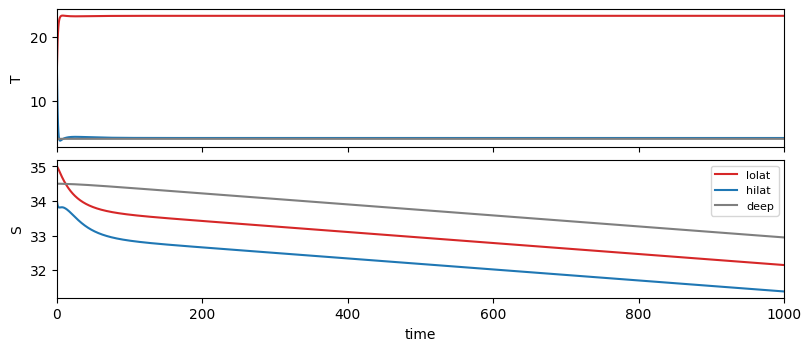

In [7]:
from tools import plot  # this imports our custom plotting functions

fig, axs = plot.boxes(time, ['T', 'S'], lolat, hilat, deep)
# NB this function returns a (fig, axs) in a similar way to the if you created the figure yourself using the subplots command.

### Sanity Check: How do I know if my model is working correctly?

We have provided a 'reference' working version of the ocean model above, which you can use to compare your model against. The working model is stored in compiled python code (`working.pyc`), which you won't be able to read directly. You can import this function using:

```python
from tools.working import ocean_model_TS

# then run the model using:
ref_time, ref_lolat, ref_hilat, ref_deep = ocean_model_TS(init_lolat, init_hilat, init_deep, 1000, 0.5)

fig, axs = plot.boxes(ref_time, ['T', 'S'], ref_lolat, ref_hilat, ref_deep)

```

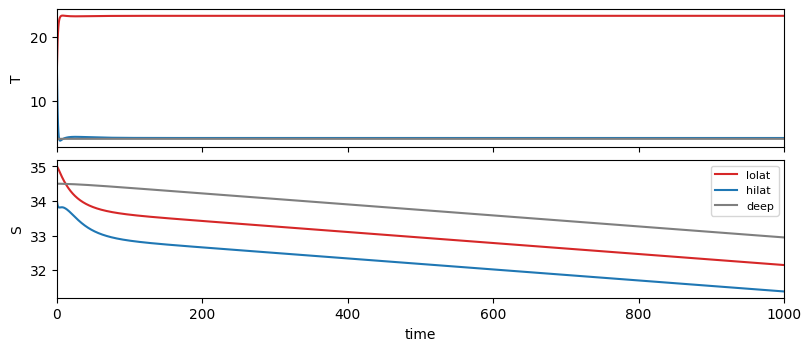

In [8]:
from tools.working import ocean_model_TS

# then run the model using:
ref_time, ref_lolat, ref_hilat, ref_deep = ocean_model_TS(init_lolat, init_hilat, init_deep, 1000, 0.5)

fig, axs = plot.boxes(ref_time, ['T', 'S'], ref_lolat, ref_hilat, ref_deep)

## Think:

1. What are the equilibrium temperature and salinity in each box (how would you extract this information from the model outputs). How realistic are these temperatures? Why might it be different to the real world?


In [ ]:
# Extract the final values of T and S from the model boxes here
T_lolat = lolat['T'][-1]
S_lolat = lolat['S'][-1]
T_hilat = hilat['T'][-1]
S_hilat = hilat['S'][-1]
# Extract the final values of T and S from the model boxes here
T_lolat = lolat['T'][-1]
S_lolat = lolat['S'][-1]
T_hilat = hilat['T'][-1]
S_hilat = hilat['S'][-1]
T_deep = deep['T'][-1]
S_deep = deep['S'][-1]
print('T for lolat:', T_lolat, 'hilat:', T_hilat, 'deep:', T_deep)
print('S for lolat:', S_lolat, 'hilat:', S_hilat, 'deep:', S_deep)

T for lolat: 23.17516419168658 hilat: 4.238149737697822 deep: 4
S for lolat: 32.24221432344574 hilat: 31.610111255324426 deep: 32.94435901793016


2. Compare the equilibration times of temperature and salinity in the low latitude surface. Why are they different?
3. Why do the surface ocean boxes equilibrate so much faster than the deep ocean?
4. Is the response of the deep or shallow boxes more similar to the Stommel model in the last practical? Why?
5. How realistic is it to represent the deep ocean as a single box? What would be the consequences of doing this?

## Lab Report Question 3: Sensitivity to Surface-Deep Exchange ($\tau_M$)

Using the model you have created above, investigate how the temperature and salinity of each box change if you halve or double the surface-deep mixing timescale ($\tau_M$).

1. Make a plot of T and S in the `hilat` box. You should see that the temperature equilibrates much faster than the salinity. Why is this?
2. Describe how these results compare to the Stommel model in the last practical.

*Hint: When modifying an input variable, it's useful to create a copy of the original input dictionary so you can reset the model conditions without re-running the entire notebook, for example:*

```python
# make copies of the original input dictionaries:
orig_lolat = init_lolat.copy()
orig_hilat = init_hilat.copy()
orig_deep = init_deep.copy()

# [your code here, which modifies the init_X dictionaries]

# at the end of your code, restore the input dictionaries to their original values:
init_lolat = orig_lolat
init_hilat = orig_hilat
init_deep = orig_deep
```

*Plotting Hint: the `plot.boxes` function we provided above might be useful in making these plots. Take a lot at the help text for the function - you can provide your own axes for it to draw the graphs on, change the style of the lines, and provide specific labels to put in the legend, for example:*

```python
plot.boxes(time, model_vars, hilat, axs=axs, ls='--', label='an interesting scenario')
```
This will then be appended to the plot label, in this case as `hilat: an interesting scenario`.

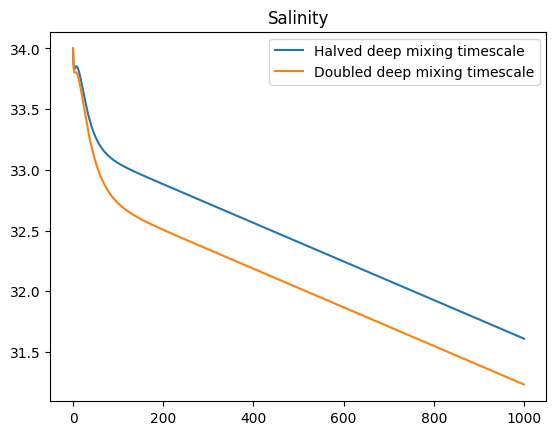

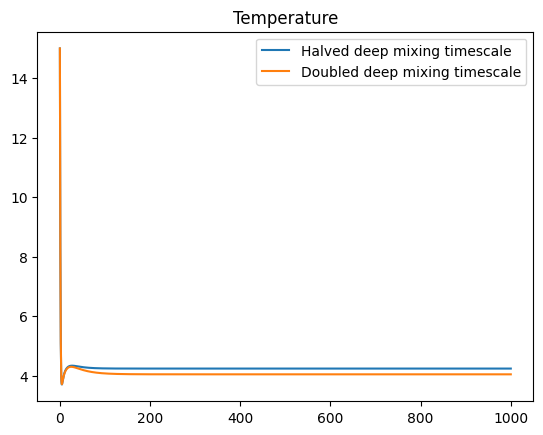

In [ ]:
# Do it here!
orig_lolat = init_lolat.copy()
orig_hilat = init_hilat.copy()
orig_deep = init_deep.copy()

# [your code here, which modifies the init_X dictionaries]

################################### halved
init_lolat['tau_M'] = init_lolat['tau_M'] / 2
init_hilat['tau_M'] = init_hilat['tau_M'] / 2


time_halved, lolat_halved, hilat_halved, deep_halved = ocean_model(init_lolat, init_hilat, init_deep, 1000, 0.5)
#fig, axs = plot.boxes(time, ['T', 'S'],hilat_halved,label='Halved deep mixing timescale')
#axs[1].set_ylim(33.5, 34)
#axs[1].set_xlim(0, 200)
init_lolat = orig_lolat
init_hilat = orig_hilat
init_deep = orig_deep


############################### doubled
orig_lolat = init_lolat.copy()
orig_hilat = init_hilat.copy()
orig_deep = init_deep.copy()


init_lolat['tau_M'] = init_lolat['tau_M'] * 2
init_hilat['tau_M'] = init_hilat['tau_M'] * 2


time_doubled, lolat_doubled, hilat_doubled, deep_doubled = ocean_model(init_lolat, init_hilat, init_deep, 1000, 0.5)
#fig, axs = plot.boxes(time, ['T', 'S'],hilat_doubled,label='Doubled deep mixing timescale')
#axs[1].set_ylim(33.5, 34)
#axs[1].set_xlim(0, 200)
init_lolat = orig_lolat
init_hilat = orig_hilat
init_deep = orig_deep

plt.plot(time,hilat_halved['S'],label='Halved deep mixing timescale')
plt.plot(time,hilat_doubled['S'],label='Doubled deep mixing timescale')
plt.legend()
plt.title('Salinity')
plt.show()

plt.plot(time,hilat_halved['T'],label='Halved deep mixing timescale')
plt.plot(time,hilat_doubled['T'],label='Doubled deep mixing timescale')
plt.legend()
plt.title('Temperature')
plt.show()




**Questions**

1.